# Exponential Smoothing for the prediction of energy consumption data over 48 hours

### 1 - Performing Triple Exponential Smoothing with energy consumption data for the years 2021-2023
### 2 - Performing Single Exponential Smoothing with energy consumption data for the years 2021-2023
### 3 - Performing Double Exponential Smoothing with energy consumption data for the years 2021-2023

In [15]:
#Install all required packages with 'conda install NAME' or with pip install NAME'
# pandas
# numpy
# matplotlib
# scikit-learn
# statsmodels

In [16]:
#Import all required libraries
import pandas as pd  # Used for data manipulation and analysis
import numpy as np  # Used for numerical operations
from pathlib import Path  # Used for filesystem path manipulation

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Used for calculating error metrics

import matplotlib.pyplot as plt  # Used for creating static, interactive, and animated visualizations
import matplotlib.dates as mdates  # Used for formatting date data on matplotlib plots

from statsmodels.tsa.holtwinters import ExponentialSmoothing  # Used for Holt-Winters exponential smoothing models
from statsmodels.tsa.api import SimpleExpSmoothing, Holt  # Used for simple and Holt's exponential smoothing

In [17]:
#To display the current environment
import sys
print(sys.executable)

/home/sarah/anaconda3/envs/BT2024SARIMAModel/bin/python


In [18]:
# Step 1 - Reading Data

## dfEnergyAll: All data from the transformer station from 2021-2023

# Path to the directory with the Excel files
directory_path = Path('/home/sarah/Documents/BT2024/All')

# Create a list of all Excel files in the directory
file_paths = list(directory_path.glob('*.xlsx'))

# List for storing individual DataFrames
dfs = []

# Loop over all file paths
for file_path in file_paths:
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Convert the 'Timestamp' column into datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Convert the 'Lastgang' column into a numeric data type, errors are treated as NaN
    df['Lastgang'] = pd.to_numeric(df['Lastgang'], errors='coerce')
    
    # Sort the DataFrame by 'Timestamp'
    df = df.sort_values(by='Timestamp')
    
    # Perform a linear interpolation for 'Lastgang' on the individual DataFrame
    df['Lastgang'] = df['Lastgang'].interpolate(method='linear')
    
    # Add the DataFrame to the list
    dfs.append(df)

# Merge all DataFrames in the list
dfEnergyAll = pd.concat(dfs).set_index('Timestamp')

# Sum the Lastgang values for identical timestamps
dfEnergyAll = dfEnergyAll.groupby('Timestamp').sum()

# Check the resulting DataFrame
print("First and last rows from dfEnergyAll:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

# Display the number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

First and last rows from dfEnergyAll:
                     Lastgang
Timestamp                    
2021-01-01 00:00:00    472.88
2021-01-01 00:15:00    498.83
2021-01-01 00:30:00    480.48
2021-01-01 00:45:00    446.74
2021-01-01 01:00:00    459.55
                     Lastgang
Timestamp                    
2023-12-31 22:45:00    833.17
2023-12-31 23:00:00    767.89
2023-12-31 23:15:00    770.04
2023-12-31 23:30:00    730.45
2023-12-31 23:45:00    744.21
Number of rows in dfEnergyAll: 105108


In [19]:
# Step 2 - Preparing the Data

# Create a complete timestamp index for the years 2021 - 2023 in 15-minute intervals
all_timestamps = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15T')

# Convert this into a DataFrame
df_all_timestamps = pd.DataFrame(all_timestamps, columns=['Timestamp'])
df_all_timestamps = df_all_timestamps.set_index('Timestamp')

# Compare the complete timestamp index with dfEnergyAll
missing_timestamps = df_all_timestamps.index.difference(dfEnergyAll.index)

print("Missing timestamps in dfEnergyAll:")
print(missing_timestamps)


# Missing timestamps
missing_timestamps = pd.DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
                                       '2021-03-28 02:30:00', '2021-03-28 02:45:00',
                                       '2022-03-27 02:00:00', '2022-03-27 02:15:00',
                                       '2022-03-27 02:30:00', '2022-03-27 02:45:00',
                                       '2023-03-26 02:00:00', '2023-03-26 02:15:00',
                                       '2023-03-26 02:30:00', '2023-03-26 02:45:00'])

# Create a DataFrame with the missing timestamps
df_missing = pd.DataFrame(index=missing_timestamps)

# Merge this DataFrame with the original DataFrame
dfEnergyAll = dfEnergyAll.combine_first(df_missing)

# Fill in the missing values. Use 'ffill' for forward fill.
dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')

print("Check after adding the missing timestamps:")
print(dfEnergyAll.loc[missing_timestamps])

# Number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

Missing timestamps in dfEnergyAll:
DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
               '2021-03-28 02:30:00', '2021-03-28 02:45:00',
               '2022-03-27 02:00:00', '2022-03-27 02:15:00',
               '2022-03-27 02:30:00', '2022-03-27 02:45:00',
               '2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
Check after adding the missing timestamps:
                     Lastgang
2021-03-28 02:00:00    372.28
2021-03-28 02:15:00    372.28
2021-03-28 02:30:00    372.28
2021-03-28 02:45:00    372.28
2022-03-27 02:00:00    554.20
2022-03-27 02:15:00    554.20
2022-03-27 02:30:00    554.20
2022-03-27 02:45:00    554.20
2023-03-26 02:00:00    520.34
2023-03-26 02:15:00    520.34
2023-03-26 02:30:00    520.34
2023-03-26 02:45:00    520.34
Number of rows in dfEnergyAll: 105120


/tmp/ipykernel_1472039/1014544308.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')


## Performing Triple Exponential Smoothing with energy consumption data for the years 2021-2023

In [20]:
# Step 3 - Creating the Triple Exponential Smoothing model and generating predictions

# Define training size (All data except the last 48 hours) and test size (48 hours)
train_size = len(dfEnergyAll) - (2 * 24 * 4)  
test_size = 2 * 24 * 4  

# Split into training and test data
train_data = dfEnergyAll['Lastgang'][:train_size]
test_data = dfEnergyAll['Lastgang'][train_size:]

# Check again for NaN values
print("NaN values in training data after frequency correction:", train_data.isnull().sum())
print("NaN values in test data after frequency correction:", test_data.isnull().sum())

NaN values in training data after frequency correction: 0
NaN values in test data after frequency correction: 0


In [21]:
# Step 3 - Creating the Triple Exponential Smoothing model and generating predictions

# Model initialization and training
# Considering an additive seasonal component and 96 as the period for daily seasonality (for 15-minute intervals)
model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=96)
fitted_model = model.fit()

# Create forecasts for the length of the test size (48 hours)
y_forecast = fitted_model.forecast(steps=test_size)

# Annotate forecast results with timestamps
forecast_series = pd.Series(y_forecast, index=test_data.index)

/home/sarah/anaconda3/envs/BT2024SARIMAModel/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


Akaike Information Criterion (AIC): 793459.7783327085
Bayesian Information Criterion (BIC): 794396.7592413137
Mean Squared Error (MSE) for the last 2 days: 12707.251187599433
Mean Absolute Error (MAE) for the last 2 days: 80.43820325071187
Root Mean Square Error (RMSE) for the last 2 days: 112.72644404752344
Mean Absolute Percentage Error (MAPE) for the last 2 days: 9.524717890484897%


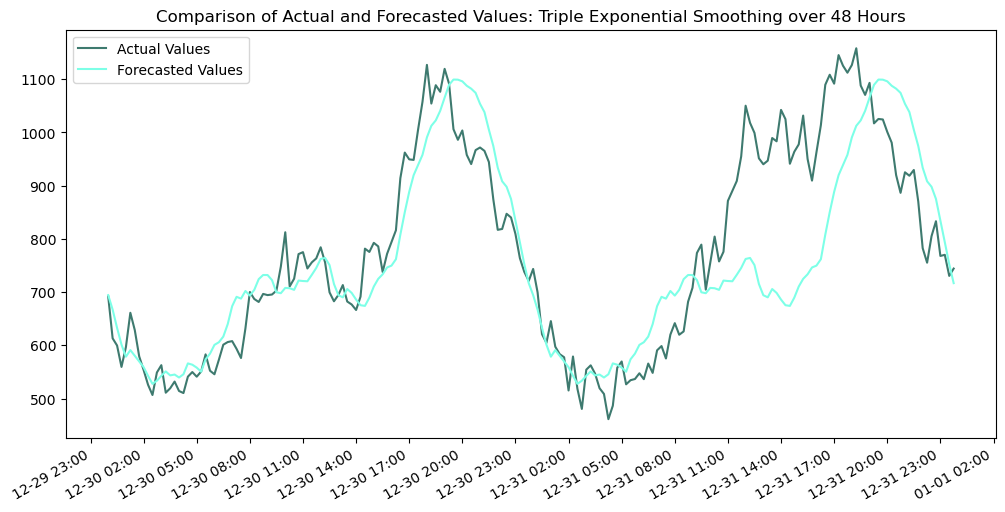

In [22]:
# Step 4 - Error metrics and visualization

# Calculate error metrics
# Output AIC and BIC
print(f"Akaike Information Criterion (AIC): {fitted_model.aic}")
print(f"Bayesian Information Criterion (BIC): {fitted_model.bic}")

mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast_series) / test_data)) * 100

# Output error metrics
print(f"Mean Squared Error (MSE) for the last 2 days: {mse}")
print(f"Mean Absolute Error (MAE) for the last 2 days: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 2 days: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 2 days: {mape}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Values', color='#3E7A6F')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Forecasted Values: Triple Exponential Smoothing over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
#plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0, 60, 15)))  # Sets the interval to 15 minutes
plt.gcf().autofmt_xdate()
plt.show()

## Performing Simple Exponential Smoothing with energy consumption data for the years 2021-2023

In [23]:
# Step 3 - Creating the Simple Exponential Smoothing model and generating predictions

# Define training and test size
train_size = len(dfEnergyAll) - (2 * 24 * 4)  # All data except the last 2 days
test_size = 2 * 24 * 4  # 2 days for prediction

# Redefine splitting into training and test data
train_data = dfEnergyAll['Lastgang'][:train_size]
test_data = dfEnergyAll['Lastgang'][train_size:]

# Check again for NaN values
print("NaN values in training data after frequency correction:", train_data.isnull().sum())
print("NaN values in test data after frequency correction:", test_data.isnull().sum())

NaN values in training data after frequency correction: 0
NaN values in test data after frequency correction: 0


In [24]:
# Step 3 - Creating the Simple Exponential Smoothing model and generating predictions

# Model initialization and training
# Here we assume that the seasonal length is 96 (15 Min * 4 * 24 hours for daily seasonality)
model = SimpleExpSmoothing(train_data)
fitted_model = model.fit()

# Forecast
y_forecast = fitted_model.forecast(steps=test_size)

# Annotate forecast results with timestamps
forecast_series = pd.Series(y_forecast, index=test_data.index)

/home/sarah/anaconda3/envs/BT2024SARIMAModel/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


Mean Squared Error (MSE) for the last 2 days: 39274.50309162266
Mean Absolute Error (MAE) for the last 2 days: 163.85394102962917
Root Mean Square Error (RMSE) for the last 2 days: 198.1779581376866
Mean Absolute Percentage Error (MAPE) for the last 2 days: 20.786266253678935%


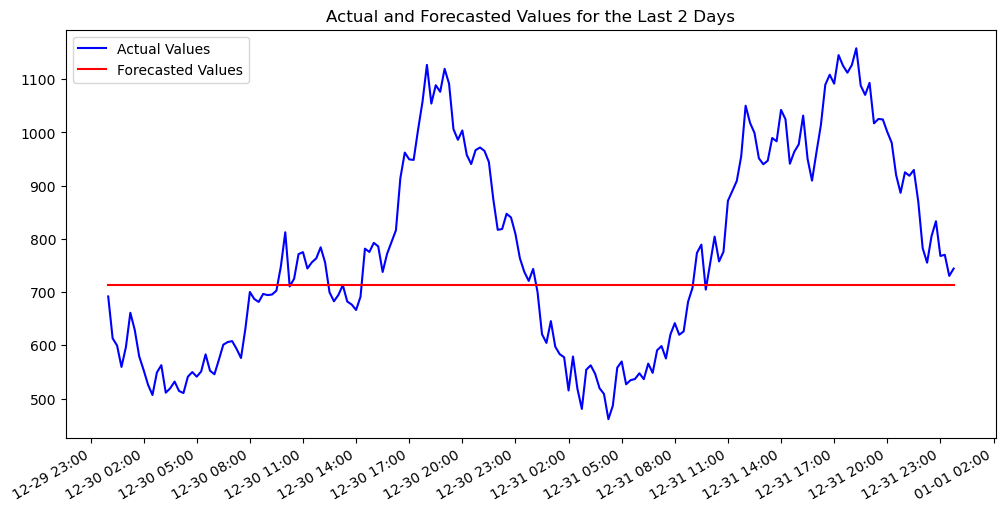

In [25]:
# Step 4 - Error metrics and visualization

# Calculate error metrics
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast_series) / test_data)) * 100

# Output error metrics
print(f"Mean Squared Error (MSE) for the last 2 days: {mse}")
print(f"Mean Absolute Error (MAE) for the last 2 days: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 2 days: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 2 days: {mape}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Values', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Values', color='red')
plt.legend()
plt.title('Actual and Forecasted Values for the Last 2 Days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.show()

## Performing Double Exponential Smoothing with energy consumption data for the years 2021-2023

In [26]:
# Step 3 - Creating the Double Exponential Smoothing model and generating predictions

# Define training and test size
train_size = len(dfEnergyAll) - (2 * 24 * 4)  # All data except the last 2 days
test_size = 2 * 24 * 4  # 2 days for prediction

# Redefine splitting into training and test data
train_data = dfEnergyAll['Lastgang'][:train_size]
test_data = dfEnergyAll['Lastgang'][train_size:]

# Check again for NaN values
print("NaN values in training data after frequency correction:", train_data.isnull().sum())
print("NaN values in test data after frequency correction:", test_data.isnull().sum())

NaN values in training data after frequency correction: 0
NaN values in test data after frequency correction: 0


In [27]:
# Step 3 - Creating the Double Exponential Smoothing model and generating predictions

# Model initialization and training
model = Holt(train_data)
fitted_model = model.fit()

# Forecast
y_forecast = fitted_model.forecast(steps=test_size)

# Annotate forecast results with timestamps
forecast_series = pd.Series(y_forecast, index=test_data.index)

/home/sarah/anaconda3/envs/BT2024SARIMAModel/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/home/sarah/anaconda3/envs/BT2024SARIMAModel/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Mean Squared Error (MSE) for the last 2 days: 141890.29354962756
Mean Absolute Error (MAE) for the last 2 days: 300.5901999837388
Root Mean Square Error (RMSE) for the last 2 days: 376.68328015672205
Mean Absolute Percentage Error (MAPE) for the last 2 days: 34.74885995630011%


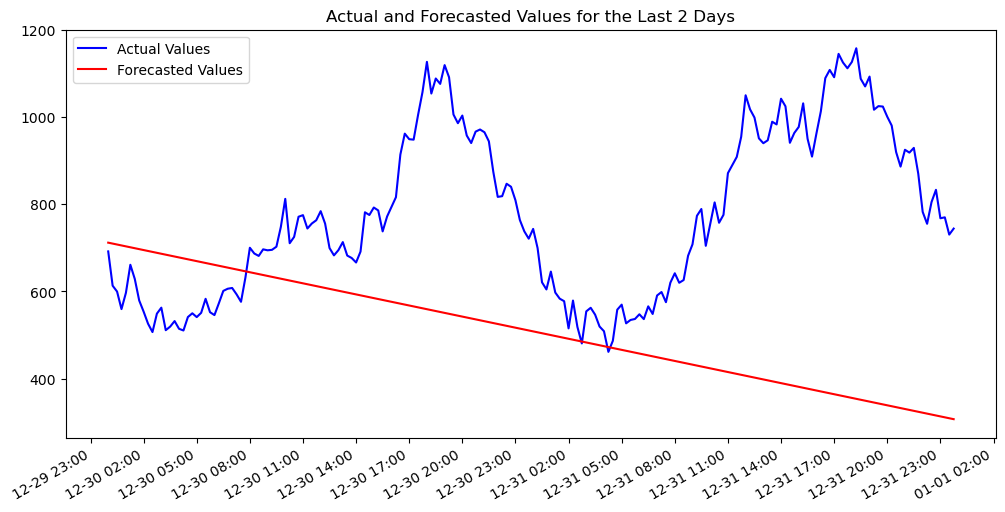

In [28]:
# Step 4 - Error metrics and visualization

# Calculate error metrics
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast_series) / test_data)) * 100

# Output error metrics
print(f"Mean Squared Error (MSE) for the last 2 days: {mse}")
print(f"Mean Absolute Error (MAE) for the last 2 days: {mae}")
print(f"Root Mean Square Error (RMSE) for the last 2 days: {rmse}")
print(f"Mean Absolute Percentage Error (MAPE) for the last 2 days: {mape}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Values', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Values', color='red')
plt.legend()
plt.title('Actual and Forecasted Values for the Last 2 Days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.show()